In [1]:
%load_ext autoreload
%autoreload 2

import os
import zipfile
import numpy as np
import scipy as sp
import biomomentum
import matplotlib.pyplot as plt
import cv2 as cv2

from matplotlib.patches import Polygon

In [2]:
# UNZIP FILES IN WORKING DIRECTORY
with zipfile.ZipFile(os.path.join(os.getcwd(), "examples.zip"), 'r') as zObject: 
    zObject.extractall( 
        path=os.getcwd()) 

In [3]:
# DYNAMIC ANALYSIS TESTING
mach_1_data = biomomentum.structures.read_mach_1_file(os.path.join(os.getcwd(), "Dynamic_data.txt"))

# DEFINE WORKING PARAMS
function = 'Sinusoid-1'
is_units_gf = "Single" in mach_1_data[function]["<INFO>"]["Load Cell Type:"] # Check if force units are gf (True or False)

# Get data of interest from mach_1_data
Time = mach_1_data[function]["<DATA>"]["Time"]
posZ = mach_1_data[function]["<DATA>"]["Position (z)"]
Fz = mach_1_data[function]["<DATA>"]["Fz"]

if is_units_gf: # If gf units convert to N
    Fz *= 0.00980665

Fz_filtered = biomomentum.Dynamic_analysis.butterworth_filter(Fz) # Filter the data to remove noise
frequency = float(mach_1_data[function]["<Sinusoid>"]["Frequency, Hz:"]) # Extract the frequence of the sin signal
Params_data_1_2, data_1_sin, data_2_sin, t_extra, data_1_extra, data_2_extra, ser_data_1, ser_data_2 = biomomentum.Dynamic_analysis.FitSinusoid(Time,  frequency, posZ, Fz, method = "trf", lossType = "soft_l1", fscale = 0.001, trim_data = True)

Amp_P = Params_data_1_2[1]
Amp_F = Params_data_1_2[5]
phase_P = Params_data_1_2[3]
phase_F = Params_data_1_2[6]

# Calculate phase offset in degrees
phase_offset = np.degrees(abs(phase_P - phase_F))

# Calculate G' (storage modulus), G'' (loss modulus), and |G| (complex modulus)
G_prime = Amp_F / Amp_P * np.cos(np.radians(phase_offset))  # G'
G_dprime = Amp_F / Amp_P * np.sin(np.radians(phase_offset)) # G''
G_mag = np.sqrt(G_prime**2 + G_dprime**2)  # |G|

# Printing dynamic metrics
print(function + " :")
print("Frequency (Hz): ", np.round(Params_data_1_2[2],6))
print("Position-z Amplitude (mm): ", np.round(Params_data_1_2[1],6))
print("Fz Amplitude (N): ", np.round(Params_data_1_2[5],6))
print("Dynamic Modulus (MPa): ", np.round(G_mag,6))
print("Phase lag (deg): ", np.round(phase_offset,6))
print("Residual Standard Error Position-z (mm): ", np.round(ser_data_1,6))
print("Residual Standard Error Force-z (N): ", np.round(ser_data_2,6))
print("===============================================")

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Sinusoid-1 :
Frequency (Hz):  0.09984
Position-z Amplitude (mm):  0.04719
Fz Amplitude (N):  43.029982
Dynamic Modulus (MPa):  911.837923
Phase lag (deg):  6.016546
Residual Standard Error Position-z (mm):  0.000311
Residual Standard Error Force-z (N):  0.550509


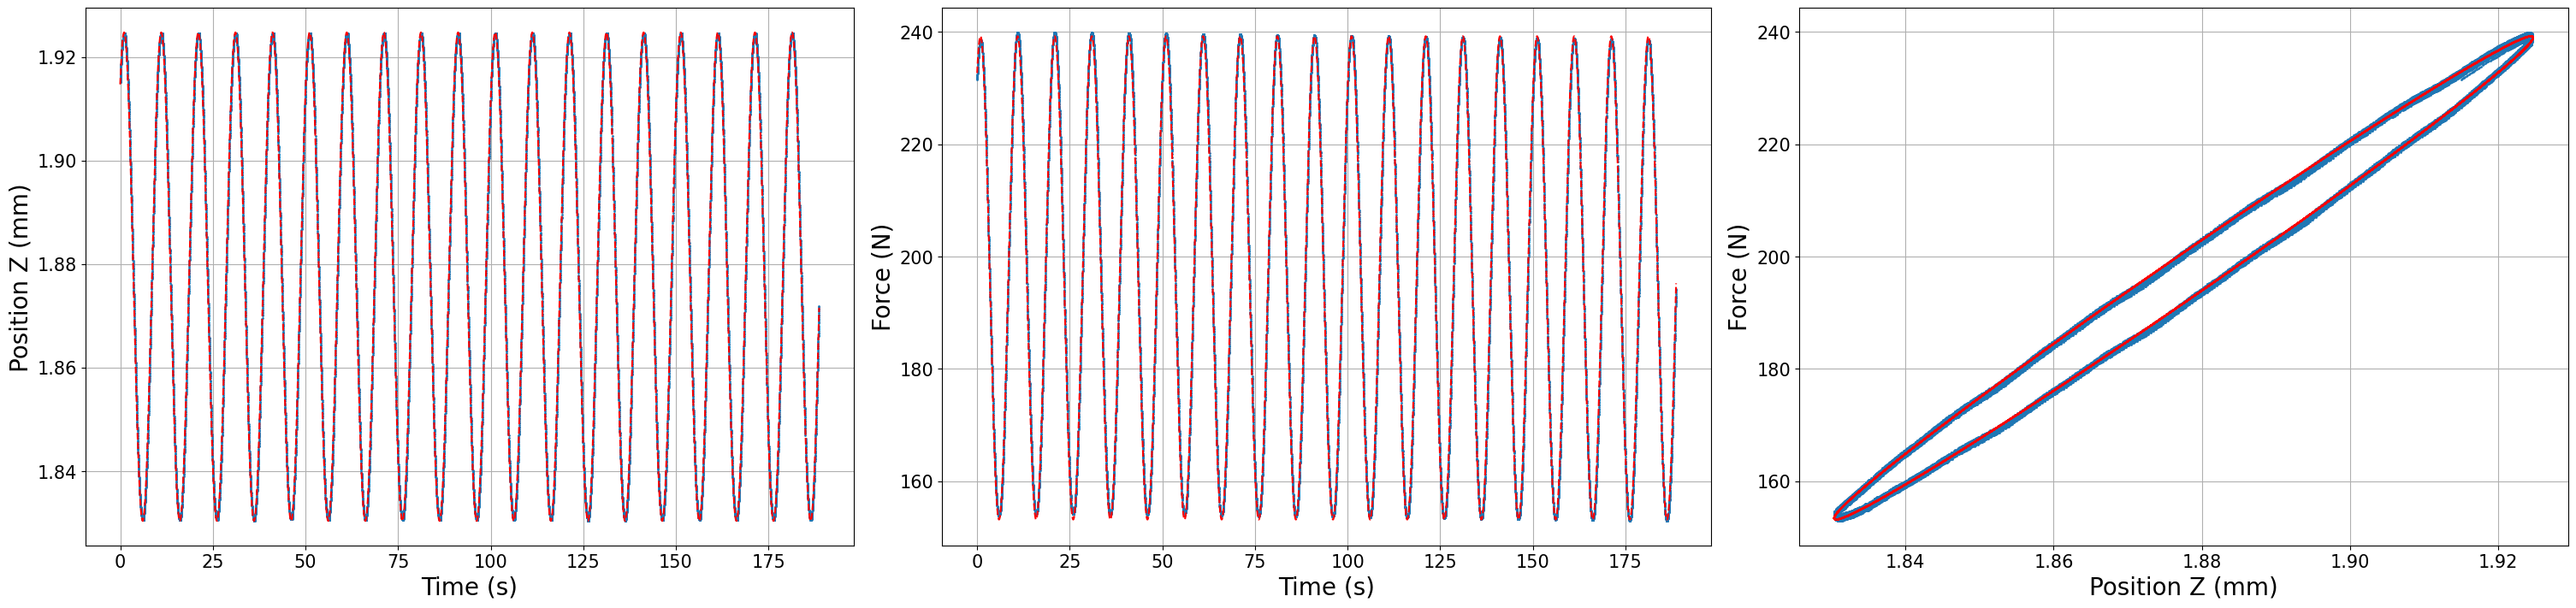

In [4]:
# PLOT SIGNAL WITH SINUSOID FIT INTO DATA
fig, axes = plt.subplots(1,3, constrained_layout = True, figsize = (30, 7))
axes[0].plot(t_extra, data_1_extra, "o", markersize = 1)
axes[0].plot(t_extra, data_1_sin, "--r")
axes[0].set_ylabel("Position Z (mm)",size=20)
axes[0].set_xlabel("Time (s)",size=20)
axes[0].tick_params(axis = 'both', which = 'major', labelsize=15)
axes[0].grid()

axes[1].plot(t_extra, data_2_extra, "o", markersize = 1)
axes[1].plot(t_extra, data_2_sin, "--r")
axes[1].set_ylabel("Force (N)",size=20)
axes[1].set_xlabel("Time (s)",size=20)
axes[1].tick_params(axis = 'both', which = 'major', labelsize=15)
axes[1].grid()

axes[2].plot(data_1_extra, data_2_extra, "o", markersize = 1)
axes[2].plot(data_1_sin, data_2_sin, "--r")
axes[2].set_ylabel("Force (N)",size=20)
axes[2].set_xlabel("Position Z (mm)",size=20)
axes[2].tick_params(axis = 'both', which = 'major', labelsize=15)
axes[2].grid()
plt.show()

In [5]:
%matplotlib qt
# STRESS RELAXATION FIT TESTING
mach_1_data = biomomentum.structures.read_mach_1_file(os.path.join(os.getcwd(), "Static_data.txt"))
function = "Stress Relaxation-1"
filemat = os.path.join(os.getcwd(), "sveff_tab.mat")
# USER INPUT PARAMS
D = 4.8 # Diameter of the cartilage upon extraction, mm
Strain = 2.5 # 2.5 percent strain / ramp
initialStrain = 10 # 10 percent strain precompression
vm = 0.36 # Poisson's ration (between 0 - 0.5) from litterature 0.36 (Garon 2007)
units_gf = "Single" in mach_1_data[function]["<INFO>"]["Load Cell Type:"]

fig, ax = plt.subplots()
for nRamp, ramp in enumerate(mach_1_data[function]["<DATA>"].values()):
    Fz = -ramp["Fz"]
    if units_gf:
        Fz = -Fz*0.00980665
    Time = ramp["Time"]
    sigZ = Fz/(np.pi * (D/2)**2)
    tau = biomomentum.Static_analysis.relaxation_constant(Fz, Time, np.argmax(Fz))
    szfit, efibril, k0, e33_eq, t0, S11, szequ, K, tau_fit, em, nm, mse, veff_poisson = biomomentum.Static_analysis.stressrelaxation_fit(Time, sigZ, D/2, Strain/100, vm, filemat = filemat)
    ax.plot(Time, sigZ, "-b")
    if nRamp == 0:
        ax.plot(Time, szfit, "--r", label = "Fit")
    else:
        ax.plot(Time, szfit, "--r")
    ax.relim()
    ax.set_ylabel("Stress (MPa)",size=20)
    ax.set_xlabel("Time (s)",size=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.autoscale_view()
    plt.draw()
    plt.pause(0.5)
    print("===============================================")
    print(f"RAMP-{nRamp + 1}")
    print("Fibril Network Modulus (MPa): ", np.round(efibril, 4))
    print("Hydraulic Permeability " + '(µm{})'.format(biomomentum.utils.get_super('2')) + "/[MPa*s]: ", np.round(k0,4))
    print("Poisson Ratio at Equilibrium: ", np.round(veff_poisson,4))
    print("Root Mean Squared Error of Fit (MPa): ", np.round(np.sqrt(mse), 4))
    print("Relaxation Constant (s): ", np.round(tau, 4))
    print("=============================================== \n")
plt.grid()
plt.legend(loc = 'lower right', fontsize = 20)
plt.show()

===============================================--------------| 0.0% Complete
RAMP-1
Fibril Network Modulus (MPa):  3.058
Hydraulic Permeability (µm²)/[MPa*s]:  0.0075
Poisson Ratio at Equilibrium:  0.0299
Root Mean Squared Error of Fit (MPa):  0.0417
Relaxation Constant (s):  54.76

RAMP-2
Fibril Network Modulus (MPa):  4.0757
Hydraulic Permeability (µm²)/[MPa*s]:  0.005
Poisson Ratio at Equilibrium:  0.0237
Root Mean Squared Error of Fit (MPa):  0.0669
Relaxation Constant (s):  60.36

RAMP-3
Fibril Network Modulus (MPa):  5.4339
Hydraulic Permeability (µm²)/[MPa*s]:  0.0036
Poisson Ratio at Equilibrium:  0.0239
Root Mean Squared Error of Fit (MPa):  0.095
Relaxation Constant (s):  62.06



Progress: |██████████████████████████████████████████████████| 100.0% Complete
WARNING! Max strain is %.2g. Curvefit is up to max strain!  0.07515567962207428


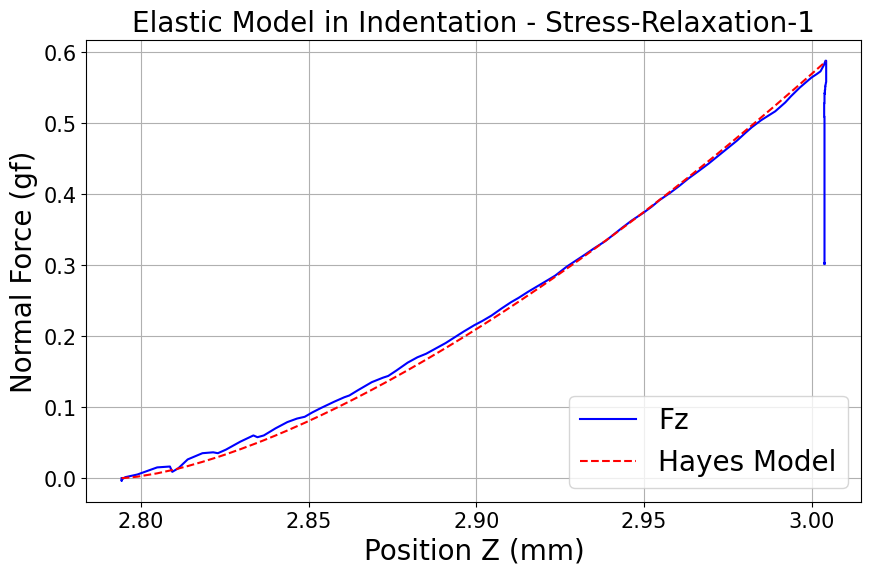

Stress-Relaxation-1
Indentation Elastic Modulus (MPa):  0.08392639479867804
 R²:  0.9992536851154108


In [10]:
# HAYES MODEL TESTING FOR UNCONFINED COMPRESSION
mach_1_data = biomomentum.structures.read_mach_1_file(os.path.join(os.getcwd(), "Hayes_data.txt"))

%matplotlib inline
# DEFINE WORKING PARAMS
function = 'Stress Relaxation-1'
is_units_gf = "Single" in mach_1_data[function]["<INFO>"]["Load Cell Type:"] # Check if force units are gf (True or False)

# Get data of interest from mach_1_data
Time = mach_1_data[function]["<DATA>"]["Ramp-1"]["Time"]
posZ = mach_1_data[function]["<DATA>"]["Ramp-1"]["Position (z)"]
Fz = mach_1_data[function]["<DATA>"]["Ramp-1"]["Fz"]

# Hayes Model Inputs
indenter_R = 0.15
poisson_coefficient = 0.5
Rsq_req = -1000000000
sample_thickness = 100000
strain = abs((posZ - posZ[0])/posZ[0])
maxStrain = np.max(strain)

G_inst, E_inst, Fit_inst, Rsq_adj_inst = biomomentum.Static_analysis.HayesElasticModel(posZ, Fz, is_units_gf, maxStrain, indenter_R, poisson_coefficient, Rsq_req, sample_thickness, True, False)

# Plotting Hayes Model Fit into data
fig = plt.figure(figsize=(10,6))
axes = fig.add_subplot(111)
axes.plot(biomomentum.utils.isNegative(posZ), Fz, "-b", label = "Fz")
axes.plot(Fit_inst[:, 0], Fit_inst[:, 1], "--r", label = "Hayes Model")
axes.set_ylabel("Normal Force (gf)",size=20)
axes.set_xlabel("Position Z (mm)",size=20)
axes.tick_params(axis = 'both', which = 'major', labelsize=15)
axes.set_title("Elastic Model in Indentation - Stress-Relaxation-1", size = 20)
plt.grid()
plt.legend(loc = 'lower right', fontsize = 20)
plt.show()
print("Stress-Relaxation-1")
print("Indentation Elastic Modulus (MPa): ", E_inst)
print(' R{}: '.format(biomomentum.utils.get_super('2')), Rsq_adj_inst)


In [11]:
# ANALYSIS MAP 
MAP_file = os.path.join(os.getcwd(), "MAP_data.map")
subSurfaces = biomomentum.structures.get_subSurfaces(MAP_file, "QP_Mean") # Load map structures
surface_1 = subSurfaces["QP"]
pos_1 = np.array(surface_1["Position"])
pos_1_ID = surface_1["Position ID"]
QP = np.array(surface_1["QP_Mean"])
boundary = np.array(surface_1["Bounds"])
all_pos = np.vstack((pos_1, boundary))
img_MAP = cv2.cvtColor(cv2.imread(subSurfaces["MAP-Info"]["Image directory"]), cv2.COLOR_BGR2RGB)

# Interpolation no smoothing
QP_2D, triangles, grid_X, grid_Y = biomomentum.utils.interpolateMAP(subSurfaces, False, False, 7, 'QP_Mean') # No boundaries
QP_2D_bounds, triangles_bounds, grid_X_bounds, grid_Y_bounds = biomomentum.utils.interpolateMAP(subSurfaces, True, False, 7, 'QP_Mean') # Include boundaries
vmin, vmax = np.min(QP), np.max(QP)

# Smooth Interpolation
QP_2D_sth, triangles_sth, grid_X_sth, grid_Y_sth = biomomentum.utils.interpolateMAP(subSurfaces, False, True, 10, 'QP_Mean') # No boundaries
QP_2D_bounds_sth, triangles_bounds_sth, grid_X_bounds_sth, grid_Y_bounds_sth = biomomentum.utils.interpolateMAP(subSurfaces, True, True, 3, 'QP_Mean') # Include boundaries

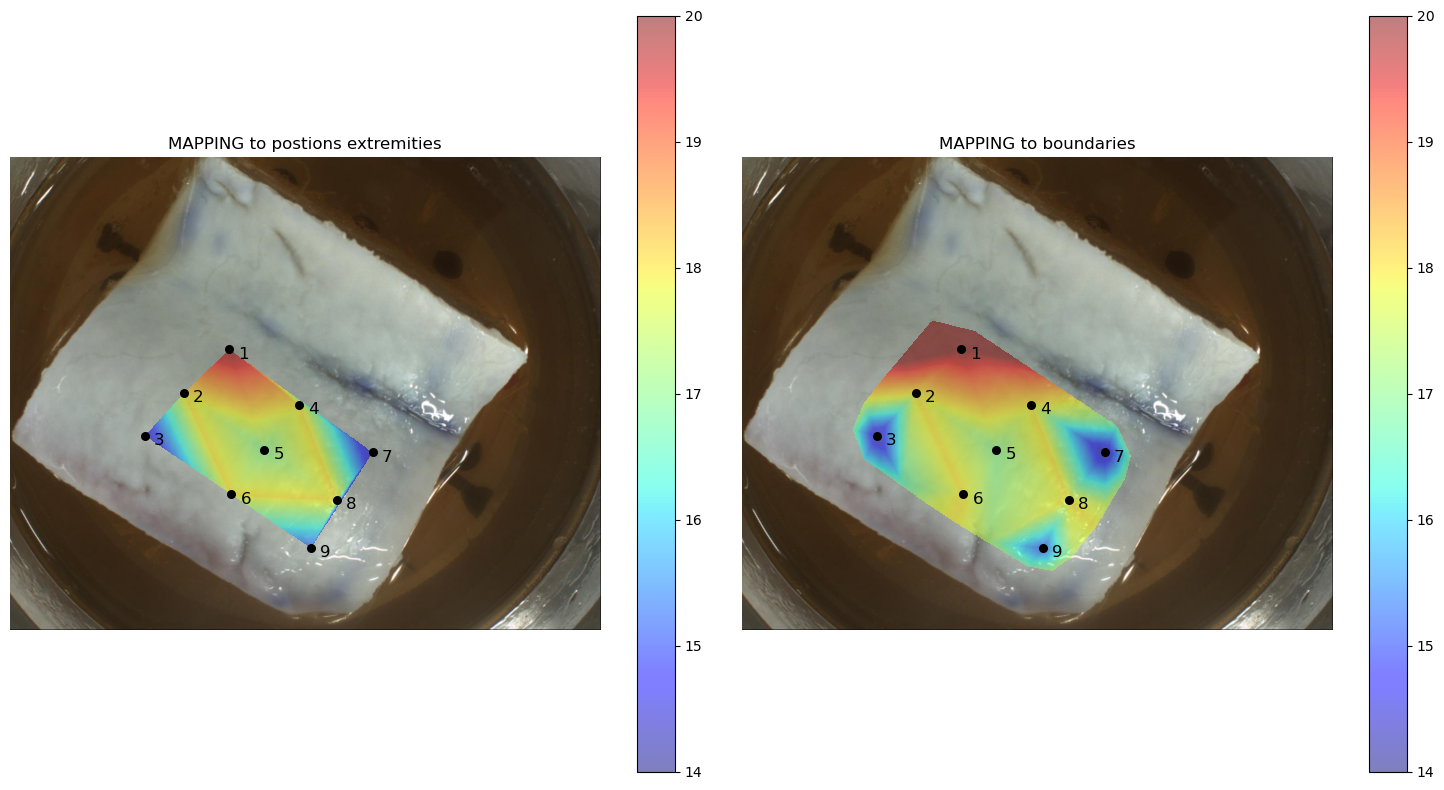

In [12]:
# PLOTTING THE INTERPOLATION MAPS WITHOUT SMOOTHING
fig = plt.figure(figsize=(15,8))
axes1 = fig.add_subplot(121)
axes1.imshow(img_MAP)
pcm = axes1.pcolormesh(grid_X, grid_Y, QP_2D, shading='auto', cmap="jet", alpha = 0.5, vmin=vmin, vmax=vmax)
axes1.scatter(pos_1[:,0].reshape(1,len(pos_1)), pos_1[:,1].reshape(1,len(pos_1)), color = "Black", s = 30)
for i, txt in enumerate(pos_1_ID):
    axes1.annotate(txt, (pos_1[i, 0], pos_1[i, 1]), (pos_1[i, 0] + 20, pos_1[i, 1] + 20), fontsize = 12)
fig.colorbar(pcm, ax=axes1)
axes1.set_title("MAPPING to postions extremities")
axes1.axis('off')
axes2 = fig.add_subplot(122)
axes2.imshow(img_MAP)
pcm = axes2.pcolormesh(grid_X_bounds, grid_Y_bounds, QP_2D_bounds, shading='auto', cmap="jet", alpha = 0.5, vmin=vmin, vmax=vmax)
axes2.scatter(pos_1[:,0].reshape(1,len(pos_1)), pos_1[:,1].reshape(1,len(pos_1)), color = "Black", s = 30)
for i, txt in enumerate(pos_1_ID):
    axes2.annotate(txt, (pos_1[i, 0], pos_1[i, 1]), (pos_1[i, 0] + 20, pos_1[i, 1] + 20), fontsize = 12)
fig.colorbar(pcm, ax=axes2)
axes2.set_title("MAPPING to boundaries")
axes2.axis('off')
plt.tight_layout()
plt.show()

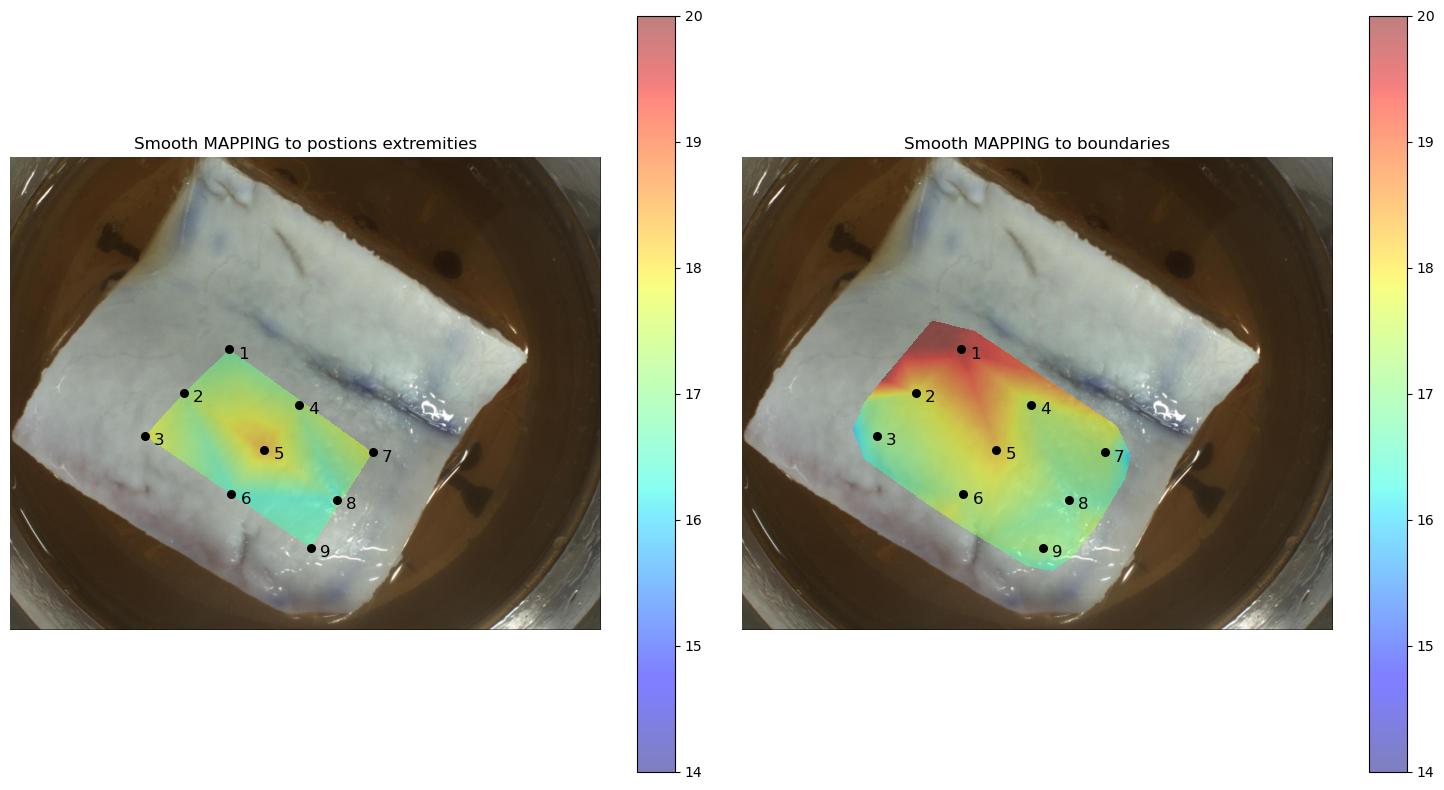

In [13]:
# PLOT THE INTERPOLATION MAPS WITH SMOOTHING
fig = plt.figure(figsize=(15,8))
axes1 = fig.add_subplot(121)
axes1.imshow(img_MAP)
pcm = axes1.pcolormesh(grid_X_sth, grid_Y_sth, QP_2D_sth, shading='auto', cmap="jet", alpha = 0.5, vmin=vmin, vmax=vmax)
axes1.scatter(pos_1[:,0].reshape(1,len(pos_1)), pos_1[:,1].reshape(1,len(pos_1)), color = "Black", s = 30)
for i, txt in enumerate(pos_1_ID):
    axes1.annotate(txt, (pos_1[i, 0], pos_1[i, 1]), (pos_1[i, 0] + 20, pos_1[i, 1] + 20), fontsize = 12)
fig.colorbar(pcm, ax=axes1)
axes1.set_title("Smooth MAPPING to postions extremities")
axes1.axis('off')
axes2 = fig.add_subplot(122)
axes2.imshow(img_MAP)
pcm = axes2.pcolormesh(grid_X_bounds_sth, grid_Y_bounds_sth, QP_2D_bounds_sth, shading='auto', cmap="jet", alpha = 0.5, vmin=vmin, vmax=vmax)
axes2.scatter(pos_1[:,0].reshape(1,len(pos_1)), pos_1[:,1].reshape(1,len(pos_1)), color = "Black", s = 30)
for i, txt in enumerate(pos_1_ID):
    axes2.annotate(txt, (pos_1[i, 0], pos_1[i, 1]), (pos_1[i, 0] + 20, pos_1[i, 1] + 20), fontsize = 12)
fig.colorbar(pcm, ax=axes2)
axes2.set_title("Smooth MAPPING to boundaries")
axes2.axis('off')
plt.tight_layout()
plt.show()